## Building a Multi Regression Model For Predicting Price Fairs 

<p>Loading The Taxi Data</p>

In [69]:
# Imports
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
import statsmodels.api as sm
import sklearn.metrics as metrics
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error


In [70]:
# Loading The Data

taxi_data = pd.read_csv("2017_Yellow_Taxi_Trip_Data (1).csv")
taxi_data.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


### Explore data with EDA

In [71]:
# Analyze and discover data, looking for correlations, missing data, outliers, and duplicates.

taxi_data_df = taxi_data.copy()

print(f"Shape of Data is {taxi_data_df.shape}")

# Information of about entire data set
taxi_data_df.info()

Shape of Data is (22699, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22

<p>Identifying the missing values and duplicates values</p>

In [72]:
# Drop Duplicates
taxi_data_df.drop_duplicates(inplace=True)

print(f"Totall Missing values {taxi_data_df.isnull().sum().sum()}")


Totall Missing values 0


## Summary Statistics of all continous Data

In [73]:
taxi_data_df.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


In [74]:
# Converting Date Time columns to date time format

taxi_data_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_data_df['tpep_pickup_datetime'], format = '%m/%d/%Y %I:%M:%S %p')
taxi_data_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_df['tpep_dropoff_datetime'], format = '%m/%d/%Y %I:%M:%S %p')

In [75]:
taxi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [76]:
taxi_data_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [77]:
# Create duration column by subtracting the dropof time with pickup time

taxi_data_df['duration'] = (taxi_data_df['tpep_dropoff_datetime'] - taxi_data_df['tpep_pickup_datetime']) / np.timedelta64(1, 'm')

### Outliers
Call taxi_data_df.info() to inspect the columns and decide which ones to check for outliers.

In [78]:
taxi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

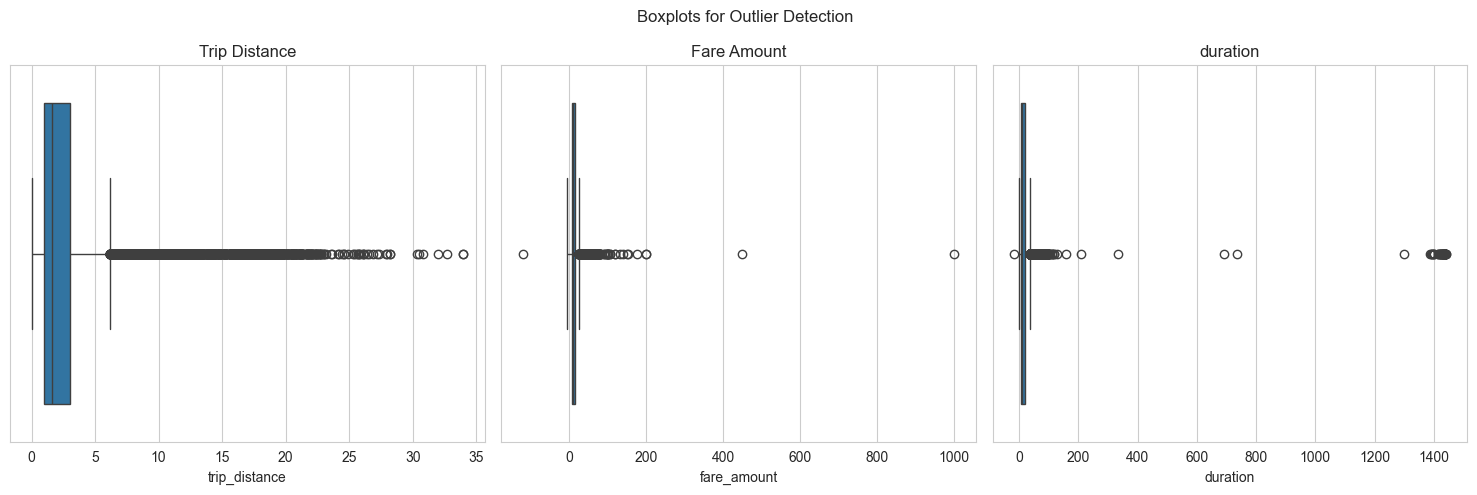

In [79]:
# Create a 1x3 plot figure
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Boxplots for Outlier Detection')

# Create individual Box plots
sns.boxplot(x=taxi_data_df['trip_distance'], ax=axes[0])
sns.boxplot(x=taxi_data_df['fare_amount'], ax=axes[1])
sns.boxplot(x=taxi_data_df['duration'], ax=axes[2])

# Create Subtitles
axes[0].set_title("Trip Distance")
axes[1].set_title("Fare Amount")
axes[2].set_title("duration")

plt.tight_layout()
plt.show()

<b>Questions:</b>

Which variable(s) contains outliers?

Are the values in the trip_distance column unbelievable?

What about the lower end? Do distances, fares, and durations of 0 (or negative values) make sense?


### Imputations
trip_distance outliers

In [80]:
# Are trip distances of 0 bad data or very short trips rounded down?
sorted(set(taxi_data_df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [81]:
# Now Calculating the count of trip_distance which are zero

taxi_data_df[taxi_data_df['trip_distance'] == 0][['trip_distance']].value_counts()

trip_distance
0.0              148
Name: count, dtype: int64

148 out of ~23,000 rides is relatively insignificant. You could impute it with a value of 0.01, but it's unlikely to have much of an effect on the model. Therefore, the trip_distance column will remain untouched with regard to outliers.

In [82]:
# Now Check Another column which is fair amount for outliers
taxi_data_df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

Question: What do you notice about the values in the fare_amount column?

The fare_amount column exhibits a wide range of values, with extremes that raise concerns.

Low values: Instances of negative fares pose issues, while zero values might be valid if a trip was abruptly canceled after logging.

High values: The dataset includes a maximum fare amount nearing $1,000, a figure highly improbable. To address this, capping high values is prudent, considering both intuition and statistical measures. Calculating the interquartile range (IQR) reveals a value of $8. Employing the standard formula Q3 + (1.5 * IQR) results in $26.50, which appears insufficient for a maximum fare cap. Thus, opting for a multiplier of 6, the cap is set at $62.50 for better alignment with the data distribution.

<b>Impute values less than $0 with 0.

<b>

In [83]:
taxi_data_df.loc[taxi_data_df['fare_amount'] < 0, 'fare_amount'] = 0
taxi_data_df['fare_amount'].min()

np.float64(0.0)

## Now impute the maximum value as Q3 + (6 * IQR).

In [84]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        
        # Reassign minimum to zero
        taxi_data_df.loc[taxi_data_df[col] < 0, col] = 0
        
        # Calculate upper threshold
        q1 = taxi_data_df[col].quantile(0.25)
        q3 = taxi_data_df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)

        print(col)
        print("3rd Quartile: ", q3)
        print("Upper Threshold: ", upper_threshold)

        # Reassign values > threshold to threshold
        taxi_data_df.loc[taxi_data_df[col] > upper_threshold, col] = upper_threshold
        print(taxi_data_df[col].describe())
        print()

In [85]:
outlier_imputer(['fare_amount'], 6)


fare_amount
3rd Quartile:  14.5
Upper Threshold:  62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



<b>duration outliers</b>

In [86]:
taxi_data_df['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The duration column has problematic values at both the lower and upper extremities.

Low values: There should be no values that represent negative time. Impute all negative durations with 0.

High values: Impute high values the same way you imputed the high-end outliers for fares: Q3 + (6 * IQR).

In [87]:
# Impute a 0 for any negative values
taxi_data_df.loc[taxi_data_df['duration'] < 0,'duration'] = 0
taxi_data_df['duration'].min()

np.float64(0.0)

In [88]:
# Impute the high outlier
outlier_imputer(['duration'],6)

duration
3rd Quartile:  18.383333333333333
Upper Threshold:  88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### Create mean_distance column

In [89]:
# Create `pickup_dropoff` column

# Convert Pickup and Dropoff Location ID Columns to Strings
taxi_data_df['PULocationID'] = taxi_data_df['PULocationID'].astype("string")
taxi_data_df['DOLocationID'] = taxi_data_df['DOLocationID'].astype("string")

# Combine pickup and dropofflocation IDs into a new column
taxi_data_df['pickup_dropoff'] = taxi_data_df['PULocationID'] + " " + taxi_data_df["DOLocationID"]

taxi_data_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 231
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 43
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 236
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 97
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,4 112


In [90]:
grouped = taxi_data_df.groupby(['pickup_dropoff'])[['trip_distance']].mean(numeric_only=True)
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [91]:
# 1. Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict('dict')

# 2. Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']


In [92]:
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
taxi_data_df['mean_distance'] = taxi_data_df['pickup_dropoff']

# 2. Map `grouped_dict` to the `mean_distance` column
taxi_data_df['mean_distance'] = taxi_data_df['mean_distance'].map(grouped_dict)

# Confirm that it worked
taxi_data_df[(taxi_data_df['PULocationID'] == '100') & (taxi_data_df['DOLocationID'] == '231')][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


<b>Purpose of This Code:</b><br>
To assign the average trip distance for each unique pickup-dropoff pair to the DataFrame. This is helpful if you want to compare actual trip distances to the average, or if you want to use this information for further analysis like predicting taxi fares.

<b>Create mean_duration column</b>

Repeat the process used to create the mean_distance column to create a mean_duration column.

In [93]:
grouped_duration = taxi_data_df.groupby(['pickup_dropoff'])[['duration']].mean(numeric_only=True)
grouped_duration_dict = grouped_duration.to_dict('dict')
grouped_duration_dict = grouped_duration_dict['duration']
taxi_data_df['mean_duration'] = taxi_data_df['pickup_dropoff'].map(grouped_duration_dict)
taxi_data_df[(taxi_data_df['PULocationID'] == '100') & (taxi_data_df['DOLocationID'] == '231')][['mean_duration']]  

,mean_duration
0,22.847222
4909,22.847222
16636,22.847222
18134,22.847222
19761,22.847222
20581,22.847222


In [94]:
taxi_data_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667


<b>Create day and month columns</b>><br>
Create two new columns, day (name of day) and month (name of month) by extracting the relevant information from the tpep_pickup_datetime column.

In [95]:
taxi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  string        
 9   DOLocationID           22699 non-null  string        
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [96]:
taxi_data_df['day'] = taxi_data_df['tpep_pickup_datetime'].dt.day_name()
taxi_data_df['month'] = taxi_data_df['tpep_pickup_datetime'].dt.month_name()   
taxi_data_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,2.76,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,Saturday,March
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,4.00,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,Tuesday,April
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,1.45,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,Friday,December
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,6.39,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,Sunday,May
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.00,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,Saturday,April


### Create rush_hour column


In [97]:
# Create 'rush_hour' col
taxi_data_df['rush_hour'] = taxi_data_df['tpep_pickup_datetime'].dt.hour

# If day is Saturday or Sunday, impute 0 in `rush_hour` column
taxi_data_df.loc[taxi_data_df['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = 0

In [98]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [99]:
# Apply the `rush_hourizer()` function to the new column
taxi_data_df.loc[(taxi_data_df['day'] != 'Saturday') & (taxi_data_df['day'] != 'Sunday'), 'rush_hour'] = taxi_data_df.apply(rush_hourizer, axis=1)

C:\Users\wtc\AppData\Local\Temp\ipykernel_4160\3628907468.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  taxi_data_df.loc[(taxi_data_df['day'] != 'Saturday') & (taxi_data_df['day'] != 'Sunday'), 'rush_hour'] = taxi_data_df.apply(rush_hourizer, axis=1)


### Scatter plot
<p>Create a scatterplot to visualize the relationship between mean_duration and fare_amount.
</p>

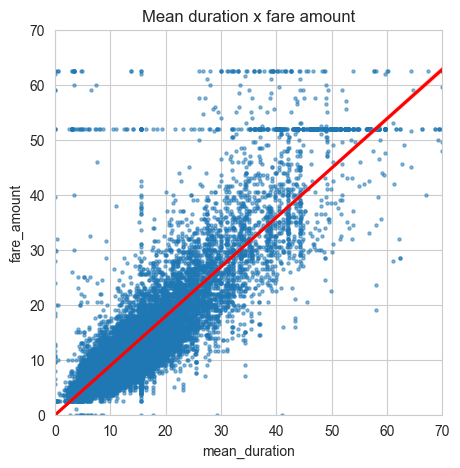

In [100]:
# Create a scatterplot to visualize the relationship between variables of interest
sns.set_style("whitegrid")
f = plt.figure(figsize = (5,5))

sns.regplot(x=taxi_data_df['mean_duration'], y=taxi_data_df['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

The mean_duration variable correlates with the target variable. But what are the horizontal lines around fare amounts of 52 dollars and 63 dollars? What are the values and how many are there?

You know what one of the lines represents. 62 dollars and 50 cents is the maximum that was imputed for outliers, so all former outliers will now have fare amounts of $62.50. What is the other line?

Check the value of the rides in the second horizontal line in the scatter plot.

In [102]:
taxi_data_df[taxi_data_df['fare_amount'] > 50][['fare_amount']].value_counts().head()


fare_amount
52.0           514
62.5            84
59.0             9
50.5             9
57.5             8
Name: count, dtype: int64

 #### Isolate modeling variables
 <p>Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

</p>

In [105]:
final_taxi_data_df = taxi_data_df.copy()

final_taxi_data_df = final_taxi_data_df.drop(['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
               'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
               'improvement_surcharge', 'total_amount', 'duration', 'pickup_dropoff', 'day', 'month'], axis=1)

final_taxi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


### Pair plot
<p>Create a pairplot to visualize pairwise relationships between fare_amount, mean_duration, and mean_distance.

</p>

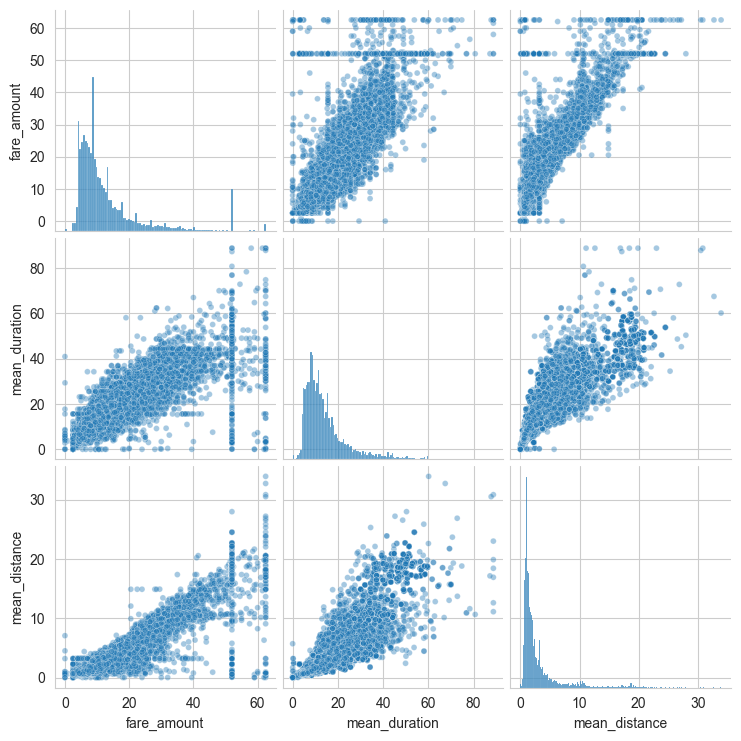

In [106]:
sns.pairplot(final_taxi_data_df,
             x_vars=["fare_amount", "mean_duration", "mean_distance"],
            y_vars=["fare_amount", "mean_duration", "mean_distance"],
            plot_kws={'alpha':0.4, 'size':5})
plt.show()

These variables all show linear correlation with each other. Investigate this further.



##  Identify correlations

In [107]:
# Correlation matrix to help determine most correlated variables
final_taxi_data_df.corr(method='pearson')

,VendorID,passenger_count,fare_amount,mean_distance,mean_duration,rush_hour
VendorID,1.000000,0.266463,0.001045,0.004741,0.001876,-0.002874
passenger_count,0.266463,1.000000,0.014942,0.013428,0.015852,-0.022035
fare_amount,0.001045,0.014942,1.000000,0.910185,0.859105,-0.020075
mean_distance,0.004741,0.013428,0.910185,1.000000,0.874864,-0.039725
mean_duration,0.001876,0.015852,0.859105,0.874864,1.000000,-0.021583
rush_hour,-0.002874,-0.022035,-0.020075,-0.039725,-0.021583,1.000000


Visualize a correlation heatmap of the data.



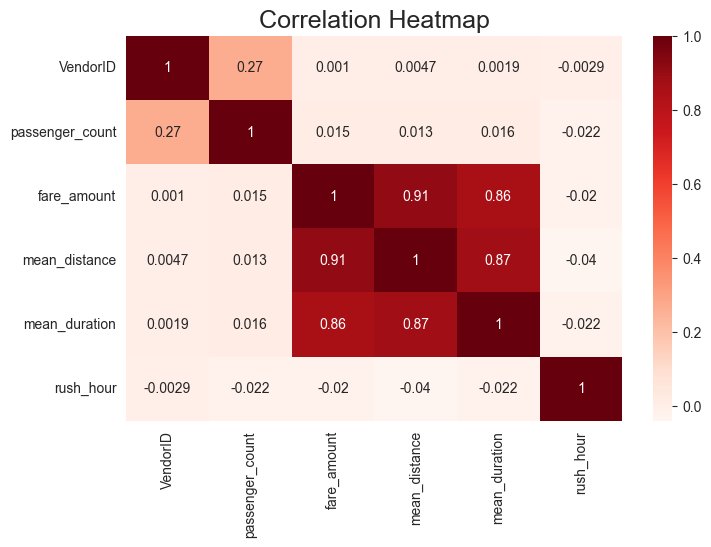

In [108]:
# Create correlation heatmap

# Create Dataframe that represents our Correlation Matrix
matrix = final_taxi_data_df.corr(method='pearson')

# Plot the Correlation Matrix
plt.figure(figsize=(8,5))
sns.heatmap(matrix, cmap='Reds', annot=True)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

<b>Question: Which variable(s) are correlated with the target variable of fare_amount?</b>

Exemplar response: mean_duration and mean_distance are both highly correlated with the target variable of fare_amount They're also both correlated with each other, with a Pearson correlation of 0.87.

Recall that highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

This model will predict fare_amount, which will be used as a predictor variable in machine learning models. Therefore, try modeling with both variables even though they are correlated.

## PACE: Construct

In [110]:
# Split data into outcome variable and features
final_taxi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


In [111]:
# Remove the target column from the features
# X = df2.drop(columns='fare_amount')
X = final_taxi_data_df.drop(columns='fare_amount')

# Set y variable
y = final_taxi_data_df['fare_amount']

# Display first few rows
X.head()

,VendorID,passenger_count,mean_distance,mean_duration,rush_hour
0,2,6,3.521667,22.847222,0
1,1,1,3.108889,24.470370,0
2,1,1,0.881429,7.250000,1
3,2,1,3.700000,30.250000,0
4,2,1,4.435000,14.616667,0


#### Pre-process data
Dummy encode categorical variables



In [113]:
X['VendorID'] = X['VendorID'].astype("str")

X = pd.get_dummies(X,drop_first=True)
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,3.521667,22.847222,0,True
1,1,3.108889,24.470370,0,False
2,1,0.881429,7.250000,1,False
3,1,3.700000,30.250000,0,True
4,1,4.435000,14.616667,0,True


### Split data into training and test sets
Create training and testing sets. The test set should contain 20% of the total samples. Set random_state=0.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)


In [116]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_trained_scaled = scaler.transform(X_train)
print("X_trained_scaled: ", X_trained_scaled)

X_trained_scaled:  [[-0.50301524  0.8694684   0.17616665 -0.64893329  0.89286563]
 [-0.50301524 -0.60011281 -0.69829589  1.54099045  0.89286563]
 [ 0.27331093 -0.47829156 -0.57301906 -0.64893329 -1.11998936]
 ...
 [-0.50301524 -0.45121122 -0.6788917  -0.64893329 -1.11998936]
 [-0.50301524 -0.58944763 -0.85743597  1.54099045 -1.11998936]
 [ 1.82596329  0.83673851  1.13212101 -0.64893329  0.89286563]]


In [117]:
# Fit your model to the training data
clf = LinearRegression().fit(X_trained_scaled, y_train)
clf

LinearRegression()

### Evaluate model

### Train data
Evaluate your model performance by calculating the residual sum of squares and the explained variance score (R^2). Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [119]:
# Evaluate the model performance on the training data
y_pred_train = clf.predict(X_trained_scaled)
r_sq = clf.score(X_trained_scaled, y_train) 

# Print Results
print("Coefficient of Determination: ", r_sq)
print("Variance Score (R^2): ", r2_score(y_train, y_pred_train))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_pred_train))
print("Mean Squared Error: ", mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of Determination:  0.8398434585044773
Variance Score (R^2):  0.8398434585044773
Mean Absolute Error:  2.186666416775413
Mean Squared Error:  17.88973296349268
Root Mean Squared Error:  4.229625629236313


### Test data
Calculate the same metrics on the test data. Remember to scale the X_test data using the scaler that was fit to the training data. Do not refit the scaler to the testing data, just transform it. Call the results X_test_scaled.

In [129]:
# Scale the X_test data
X_test_scaled = scaler.transform(X_test)

# Evaluate the model performance on the testing data
y_pred_test = clf.predict(X_test_scaled)
r_sq_test = clf.score(X_test_scaled, y_test)

# Print Results
print("Coefficient of Determination: ", r_sq_test)
print("Variance Score (R^2): ", r2_score(y_test, y_pred_test))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_test))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred_test))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of Determination:  0.8682583641795454
Variance Score (R^2):  0.8682583641795454
Mean Absolute Error:  2.133654984059386
Mean Squared Error:  14.326454156998944
Root Mean Squared Error:  3.785030271609323


 The model performance is high on both training and test sets, suggesting that there is little bias in the model and that the model is not overfit. In fact, the test scores were even better than the training scores.

For the test data, an R2 of 0.868 means that 86.8% of the variance in the fare_amount variable is described by the model.

The mean absolute error is informative here because, for the purposes of the model, an error of two is not more than twice as bad as an error of one.

## PACE: Execute

### Results
Use the code cell below to get actual,predicted, and residual for the testing set, and store them as columns in a results dataframe.

In [121]:
# Create a `results` dataframe
results = pd.DataFrame(data={'actual' : y_test,
                            'predicted' : y_pred_test.ravel()})

results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,12.356503,1.643497
18134,28.0,16.314595,11.685405
4655,5.5,6.726789,-1.226789
7378,15.5,16.227206,-0.727206
13914,9.5,10.536408,-1.036408


### Visualize model results
Create a scatterplot to visualize actual vs. predicted.



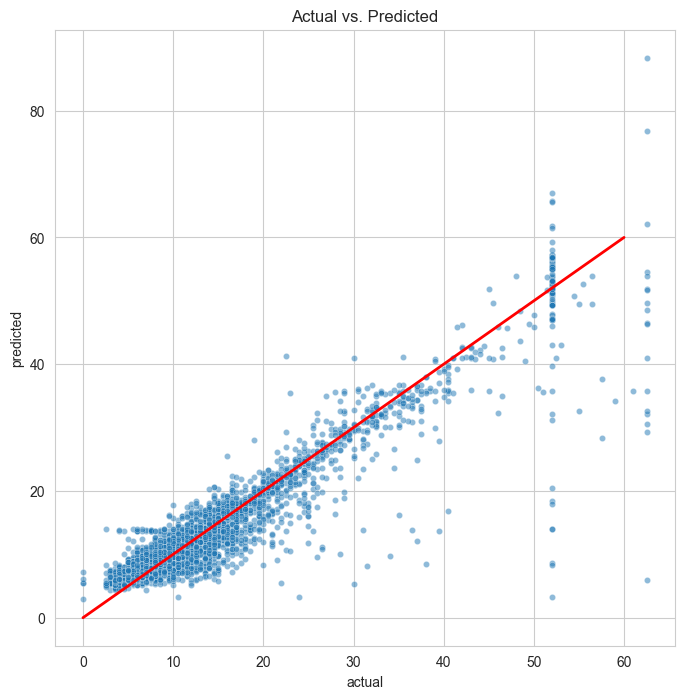

In [122]:
# Create a scatterplot to visualize `predicted` over `actual`
plt.figure(figsize=(8,8))
sns.set_style(style='whitegrid')
sns.scatterplot(data=results,
               x='actual',
               y='predicted',
               alpha=0.5,
               s=20
               )

# Draw a line to see what the results would look like if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title("Actual vs. Predicted")
plt.show()

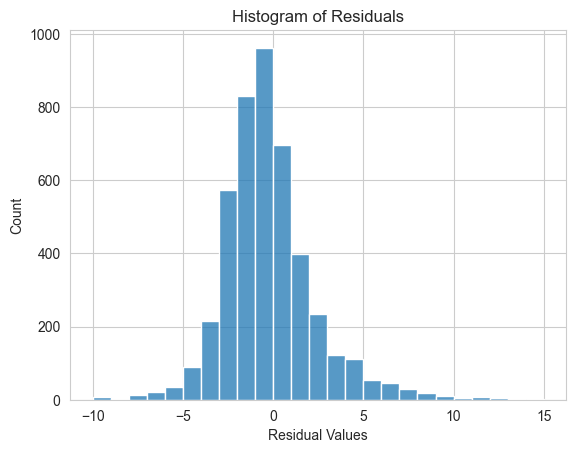

In [124]:
# Visualize the distribution of the residuals using a histogram.

# Visualize the distribution of the `residuals`
fig = sns.histplot(results['residual'], bins=np.arange(-10,16,1))
fig.set_xlabel("Residual Values")
fig.set_title("Histogram of Residuals")
plt.show()


In [125]:
# Calculate residual mean
results['residual'].mean()

np.float64(-0.015442621528680771)

#### Create a scatterplot of residuals over predicted.



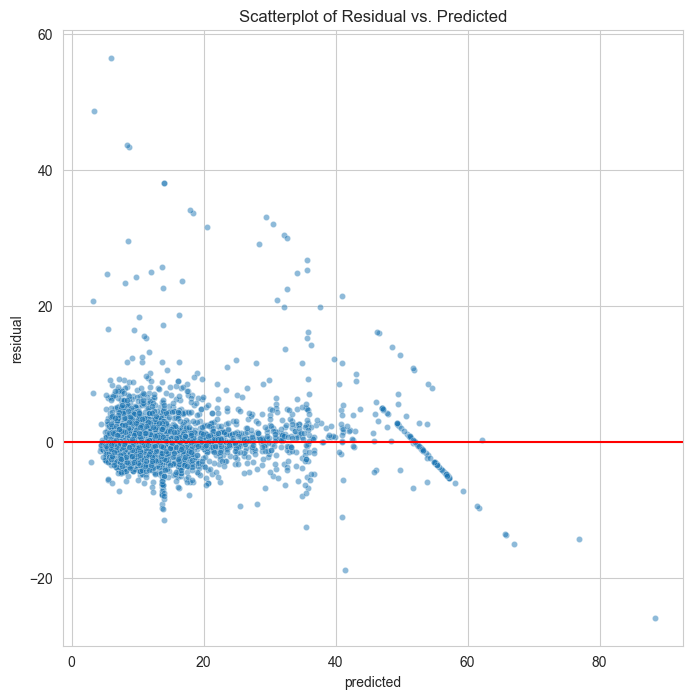

In [126]:
# Create a scatterplot of `residuals` over `predicted`
plt.figure(figsize=(8,8))
sns.set_style(style='whitegrid')
sns.scatterplot(data=results,
               x='predicted',
               y='residual',
               alpha=0.5,
               s=20
               )

# Draw a line to see what the results would look like if the model were perfect
plt.axhline(0, c='red')
plt.title("Scatterplot of Residual vs. Predicted")
plt.show()

### Coefficients
Use the coef_ attribute to get the model's coefficients. The coefficients are output in the order of the features that were used to train the model. Which feature had the greatest effect on trip fare?

In [127]:
# Output the model's coefficients
coefficient = pd.DataFrame(data=clf.coef_, columns=['Coefficients'], index=X.columns)
coefficient

,Coefficients
passenger_count,0.030825
mean_distance,7.133867
mean_duration,2.812115
rush_hour,0.110233
VendorID_2,-0.054373


What do these coefficients mean? How should they be interpreted?

The coefficients reveal that mean_distance was the feature with the greatest weight in the model's final prediction. A common misinterpretation is that for every mile traveled, the fare amount increases by a mean of $7.13. This is incorrect. The data used to train the model was standardized with StandardScaler(). As such, the units are no longer miles. In other words, you cannot say "for every mile traveled...", as stated above. The correct interpretation of this coefficient is: controlling for other variables, for every +1 change in standard deviation, the fare amount increases by a mean of $7.13.

Note also that because some highly correlated features were not removed, the confidence interval of this assessment is wider.

So, translate this back to miles instead of standard deviation (i.e., unscale the data).

Calculate the standard deviation of mean_distance in the X_train data.

Divide the coefficient (7.133867) by the result to yield a more intuitive interpretation.

In [128]:
# 1. Calculate SD of `mean_distance` in X_train data
print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print(7.133867 / X_train['mean_distance'].std())

3.574812975256436
1.9955916713344308


Now you can make a more intuitive interpretation: for every 3.57 miles traveled, the fare increased by a mean of $7.13. Or, reduced: for every 1 mile traveled, the fare increased by a mean of $2.00.